# Spiking Data Exploration 
This notebook has exploration on how spiking data is generated for MNIST

In [1]:
import os
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm

In [2]:
from time import time as t

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_weights, get_square_assignments
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_weights,
    plot_assignments,
    plot_performance,
    plot_voltages,
)


In [3]:
seed = 0
n_neurons = 100
n_epochs = 1
n_test = 10000
n_workers = -1
exc = 22.5
inh = 120
theta_plus = 0.05
time = 10 # Reduced to 10 so that visualization is simpler. Normally it is 250
dt = 1.0
intensity = 128
progress_interval = 10
update_interval = 25
train = True
plot = False
gpu = False

In [4]:
# Sets up Gpu use
if gpu:
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)

# Determines number of workers to use
if n_workers == -1:
    n_workers = gpu * 4 * torch.cuda.device_count()

if not train:
    update_interval = n_test

n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
start_intensity = intensity


In [5]:
# Build network.
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=exc,
    inh=inh,
    dt=dt,
    norm=78.4,
    theta_plus=theta_plus,
    inpt_shape=(1, 28, 28),
)

In [6]:
# Directs network to GPU
if gpu:
    network.to("cuda")

In [7]:
# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

In [8]:
# Record spikes during the simulation.
spike_record = torch.zeros(update_interval, time, n_neurons)

# Neuron assignments and spike proportions.
n_classes = 10
assignments = -torch.ones(n_neurons)
proportions = torch.zeros(n_neurons, n_classes)
rates = torch.zeros(n_neurons, n_classes)

# Sequence of accuracy estimates.
accuracy = {"all": [], "proportion": []}

# Voltage recording for excitatory and inhibitory layers.
exc_voltage_monitor = Monitor(network.layers["Ae"], ["v"], time=time)
inh_voltage_monitor = Monitor(network.layers["Ai"], ["v"], time=time)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")

In [9]:
# Set up monitors for spikes and voltages
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=time)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

In [10]:
inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None

Spikes for 10 time steps
Time Step: 1


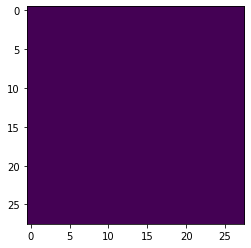

Time Step: 2


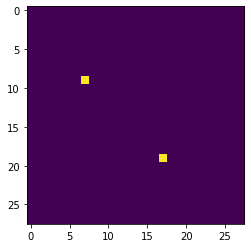

Time Step: 3


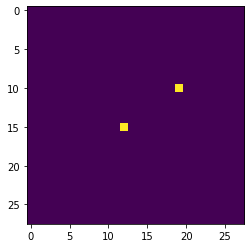

Time Step: 4


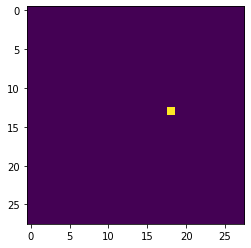

Time Step: 5


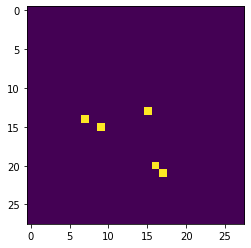

Time Step: 6


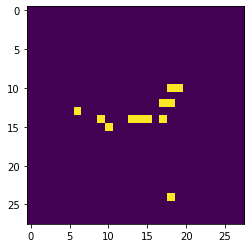

Time Step: 7


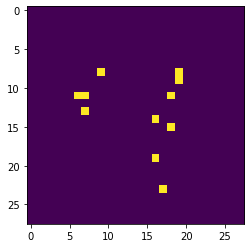

Time Step: 8


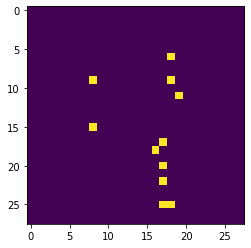

Time Step: 9


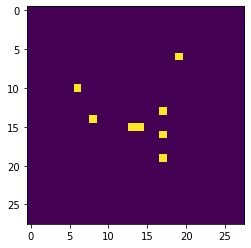

Time Step: 10


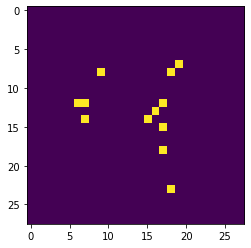

Original image


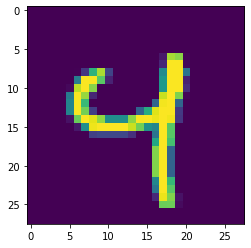

In [47]:
# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
)

for step, batch in enumerate(dataloader):
    # Get next input sample.

    inputs = {"X": batch["encoded_image"].view(time, 1, 1, 28, 28)}
    print("Spikes for 10 time steps")
    for time_step in range(time):
        print("Time Step:", time_step + 1)
        plt.figure()
        plt.imshow(inputs["X"][time_step][0,0,:,:]) 
        plt.show()  # display it
    print("Original image")
    plt.figure()
    plt.imshow(batch["image"][0,0,:,:]) 
    plt.show()  # display it
    break

In [49]:
time = 250 # Now change the time steps to 250 to observe spikes 

# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

1 9 tensor(32.1255)


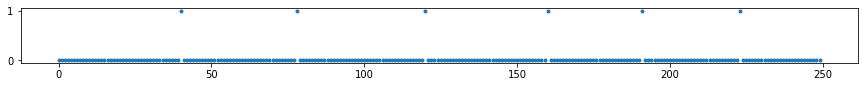

1 10 tensor(128.)


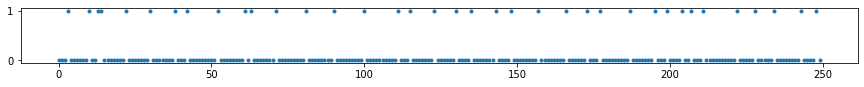

2 9 tensor(95.8745)


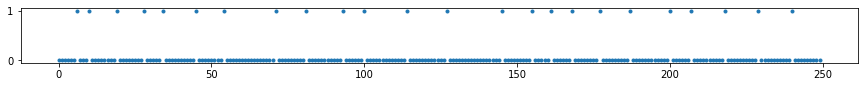

2 10 tensor(128.)


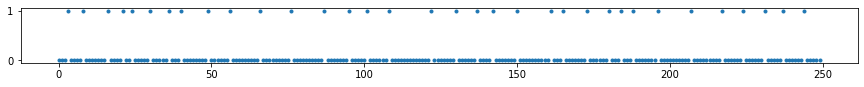

3 9 tensor(128.)


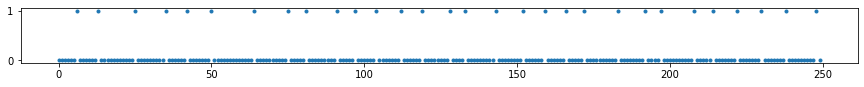

3 10 tensor(64.2510)


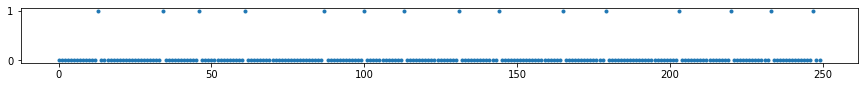

4 8 tensor(64.2510)


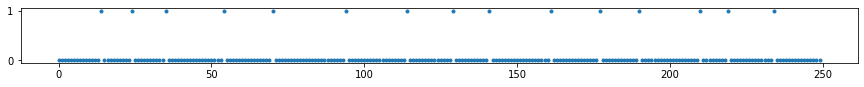

4 9 tensor(128.)


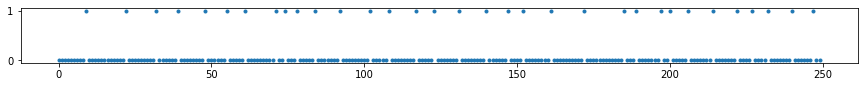

4 10 tensor(64.2510)


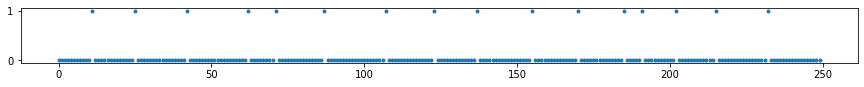

5 8 tensor(128.)


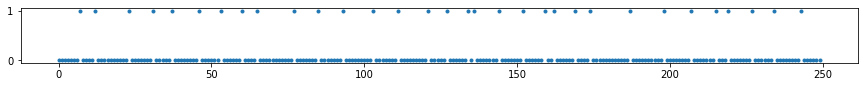

5 9 tensor(128.)


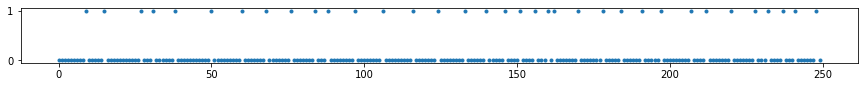

5 10 tensor(64.2510)


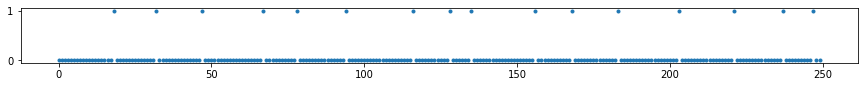

6 7 tensor(64.2510)


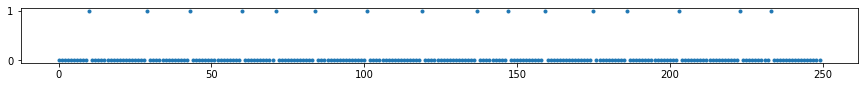

6 8 tensor(128.)


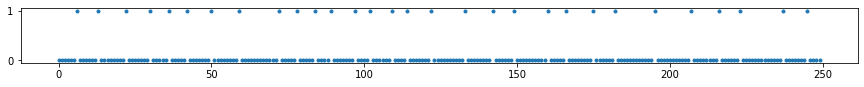

6 9 tensor(128.)


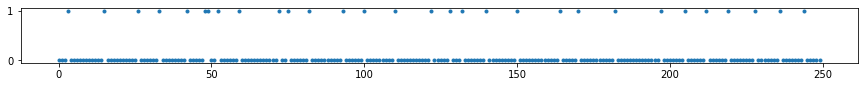

7 7 tensor(64.2510)


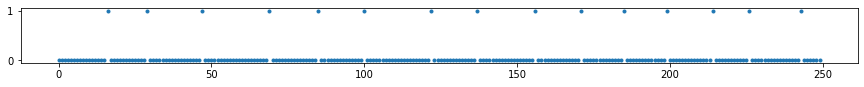

7 8 tensor(128.)


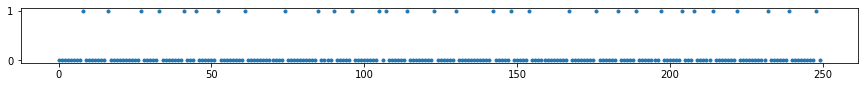

7 9 tensor(95.8745)


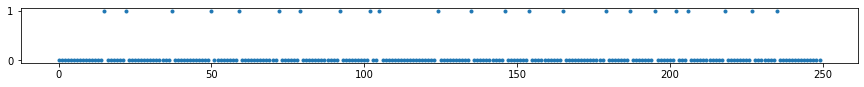

8 7 tensor(95.8745)


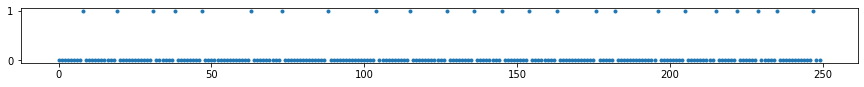

8 8 tensor(128.)


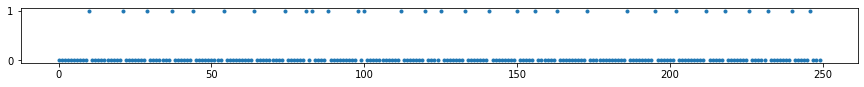

8 9 tensor(64.2510)


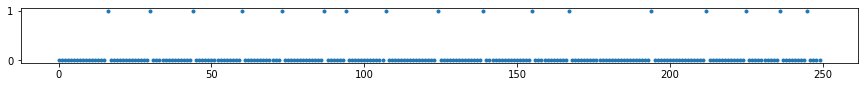

9 7 tensor(128.)


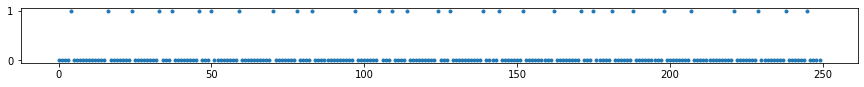

9 8 tensor(128.)


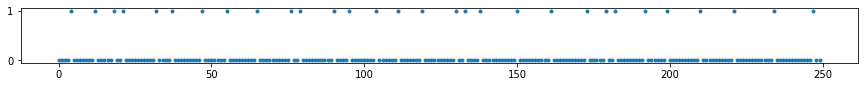

9 17 tensor(64.2510)


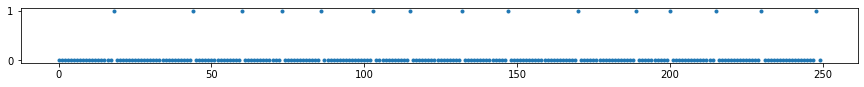

9 18 tensor(64.2510)


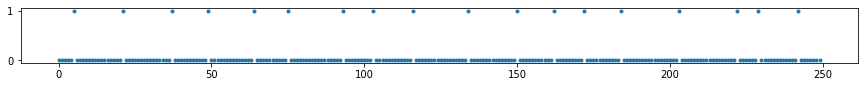

9 19 tensor(64.2510)


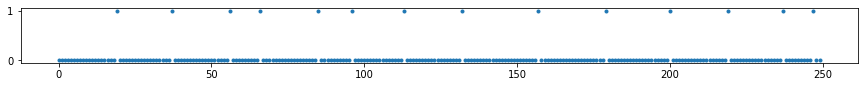

9 20 tensor(32.1255)


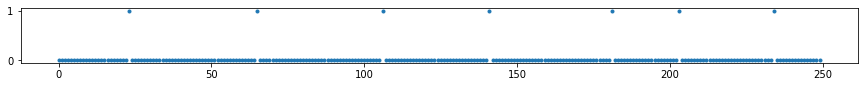

10 6 tensor(32.1255)


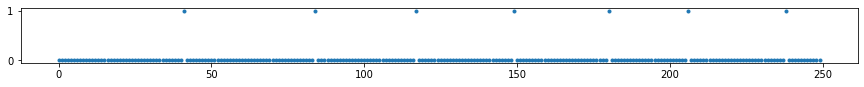

10 7 tensor(128.)


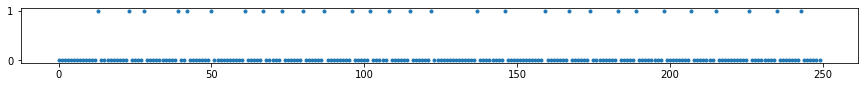

10 8 tensor(128.)


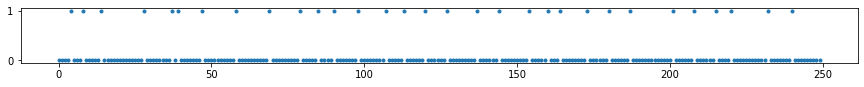

10 15 tensor(32.1255)


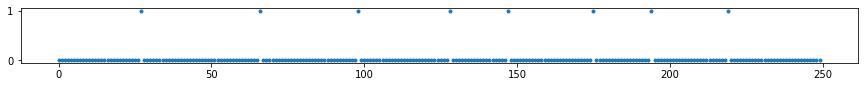

10 16 tensor(95.8745)


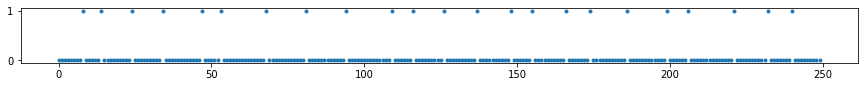

10 17 tensor(128.)


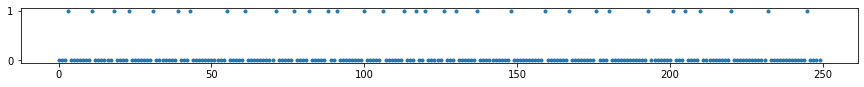

10 18 tensor(128.)


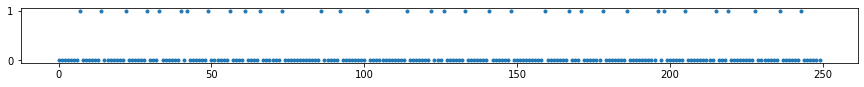

10 19 tensor(128.)


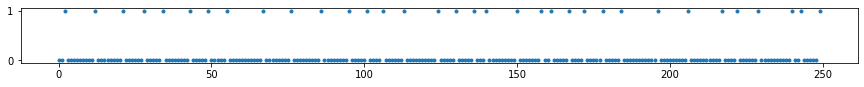

10 20 tensor(128.)


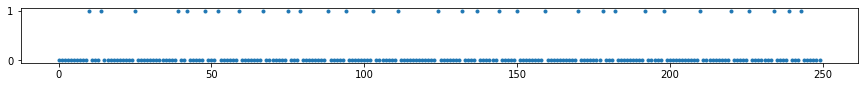

10 21 tensor(128.)


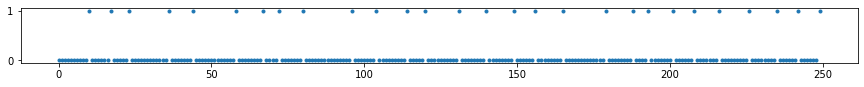

10 22 tensor(64.2510)


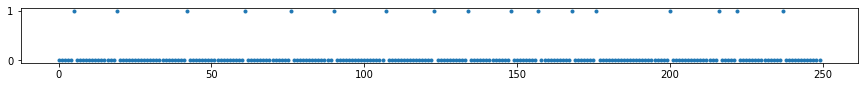

11 6 tensor(64.2510)


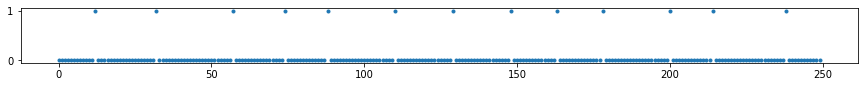

11 7 tensor(128.)


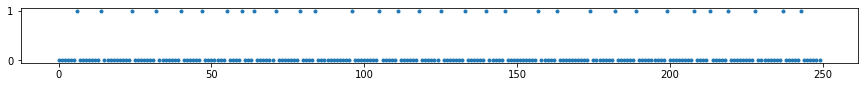

11 8 tensor(128.)


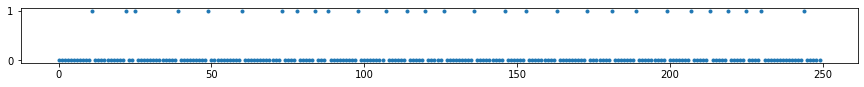

11 14 tensor(32.1255)


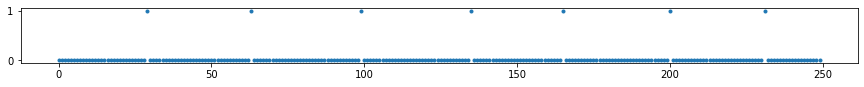

11 15 tensor(128.)


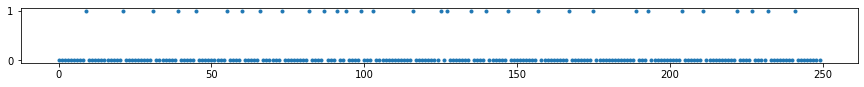

11 16 tensor(128.)


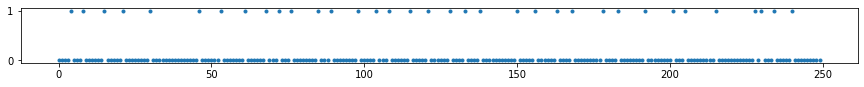

11 17 tensor(128.)


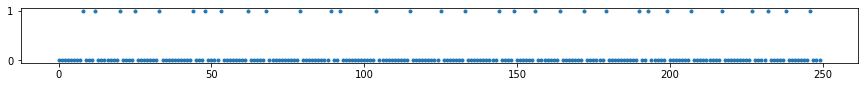

11 18 tensor(128.)


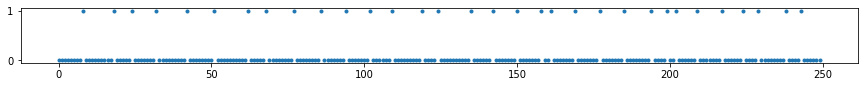

11 19 tensor(128.)


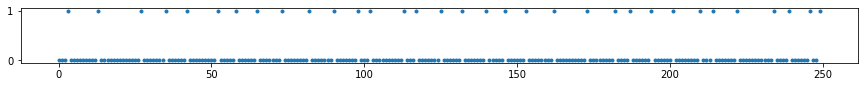

11 20 tensor(128.)


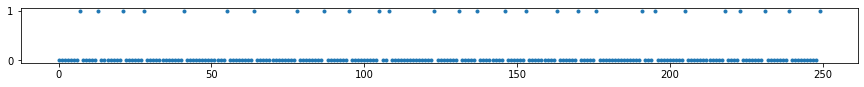

11 21 tensor(128.)


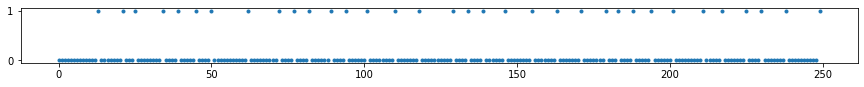

11 22 tensor(128.)


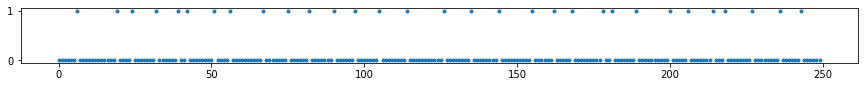

11 23 tensor(128.)


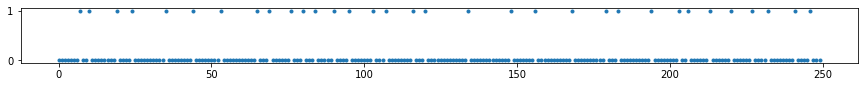

12 6 tensor(128.)


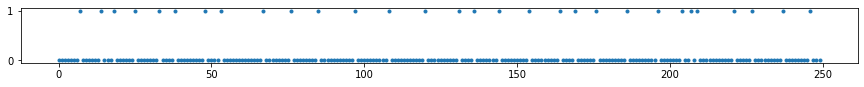

12 7 tensor(128.)


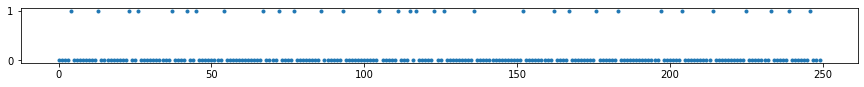

12 8 tensor(128.)


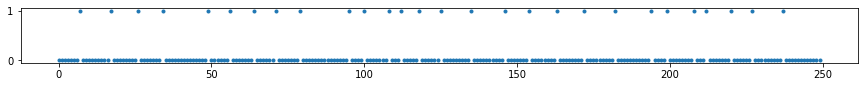

12 14 tensor(95.8745)


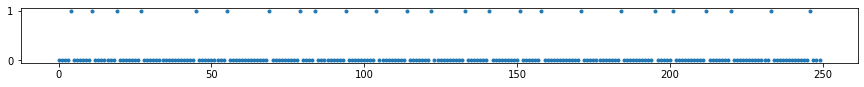

12 15 tensor(128.)


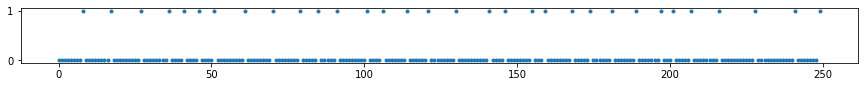

12 16 tensor(128.)


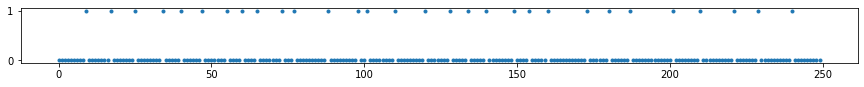

12 17 tensor(128.)


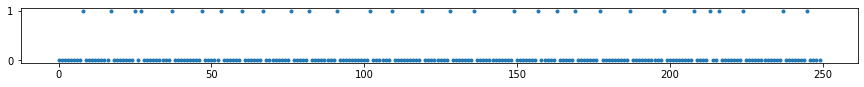

12 18 tensor(128.)


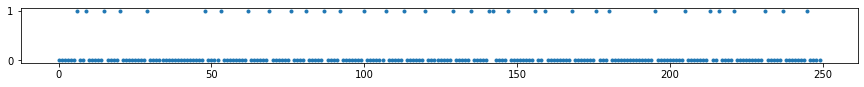

12 19 tensor(128.)


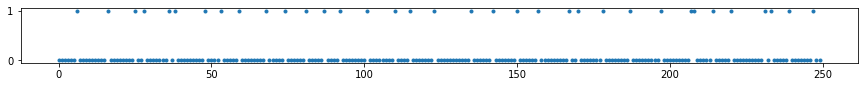

12 20 tensor(128.)


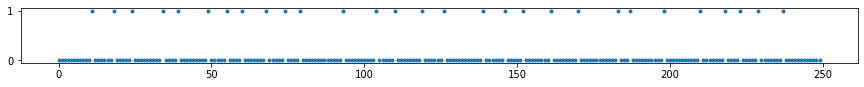

12 21 tensor(128.)


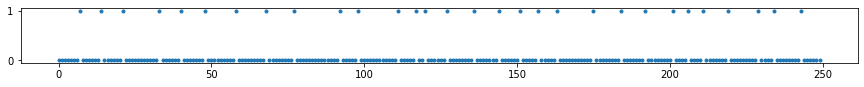

12 22 tensor(128.)


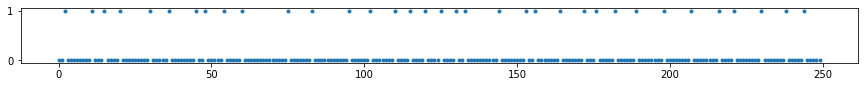

12 23 tensor(128.)


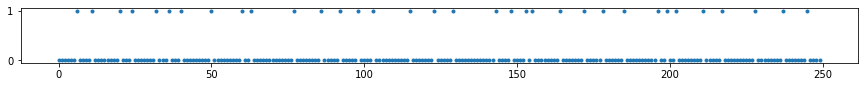

13 6 tensor(128.)


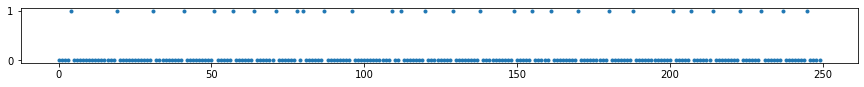

13 7 tensor(128.)


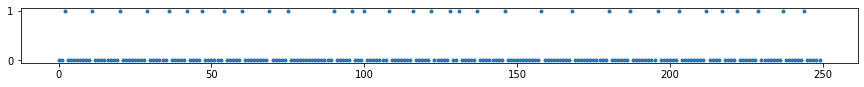

13 8 tensor(128.)


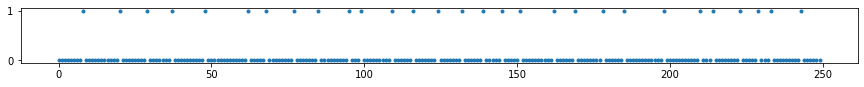

13 9 tensor(95.8745)


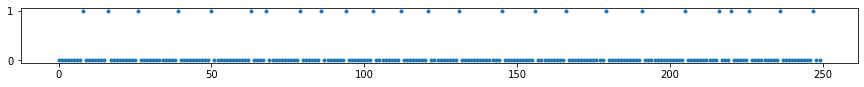

13 13 tensor(32.1255)


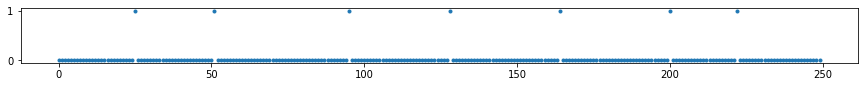

13 14 tensor(128.)


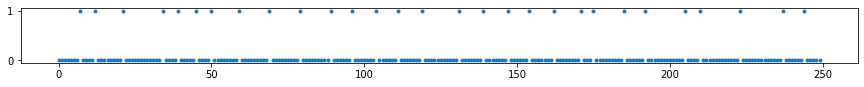

13 15 tensor(128.)


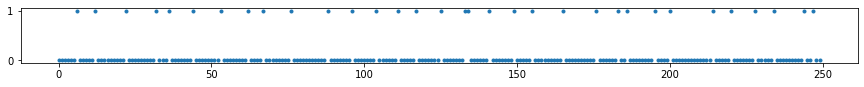

13 16 tensor(64.2510)


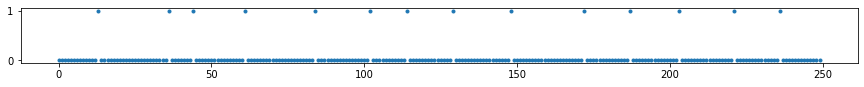

13 17 tensor(64.2510)


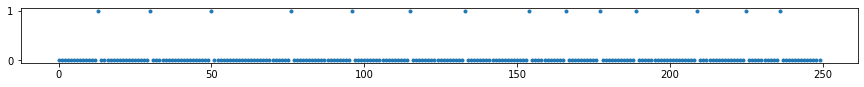

13 18 tensor(64.2510)


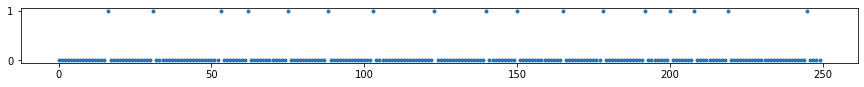

13 19 tensor(95.8745)


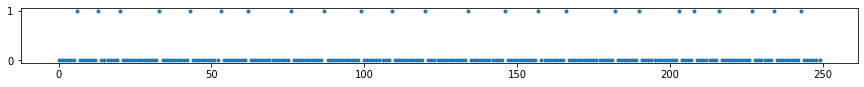

13 20 tensor(128.)


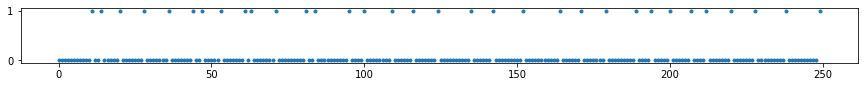

13 21 tensor(128.)


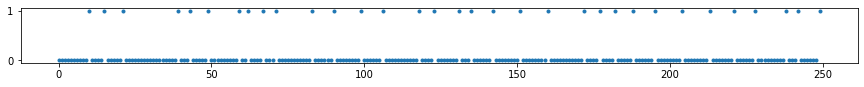

13 22 tensor(128.)


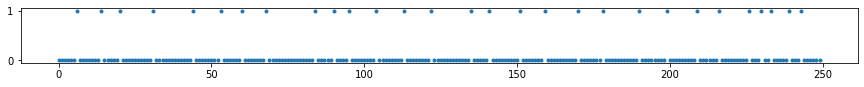

13 23 tensor(128.)


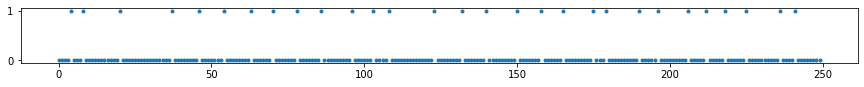

14 6 tensor(128.)


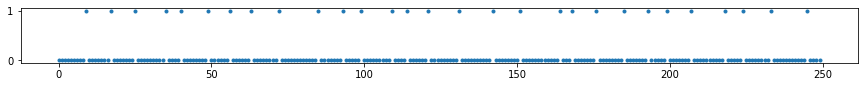

14 7 tensor(128.)


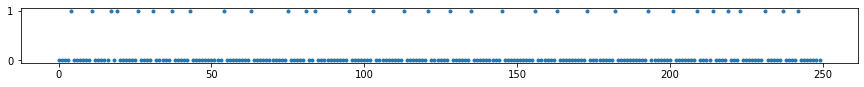

14 8 tensor(128.)


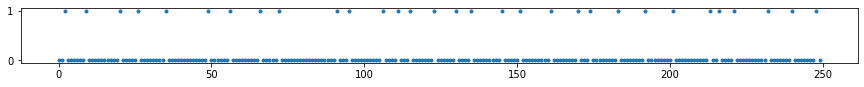

14 9 tensor(128.)


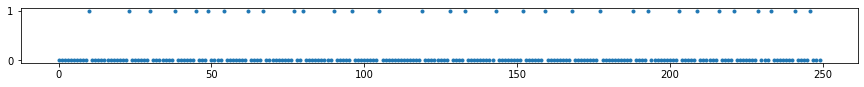

14 10 tensor(32.1255)


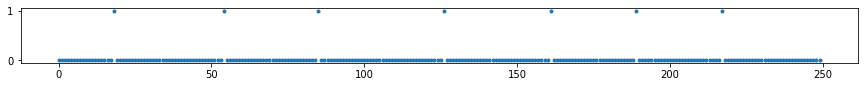

14 13 tensor(64.2510)


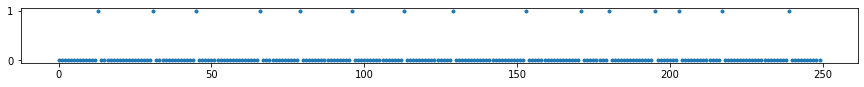

14 14 tensor(128.)


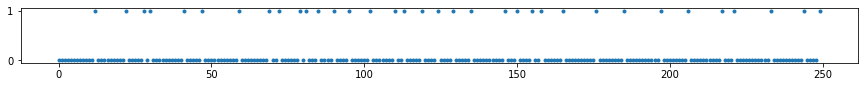

14 15 tensor(128.)


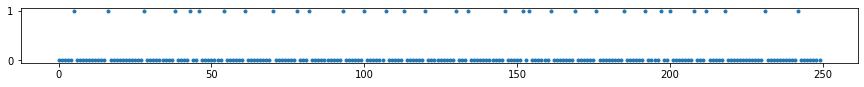

14 21 tensor(128.)


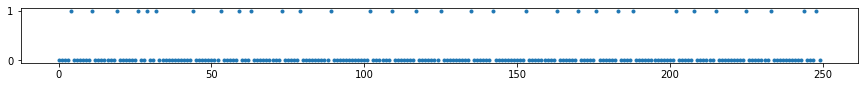

14 22 tensor(128.)


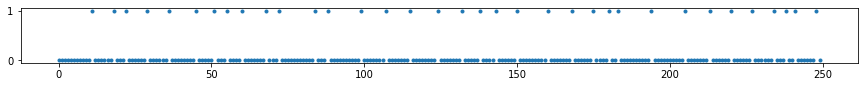

14 23 tensor(128.)


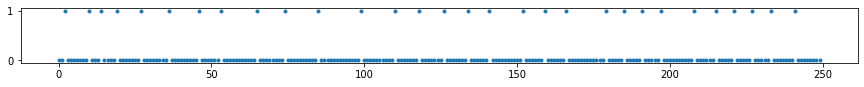

15 6 tensor(128.)


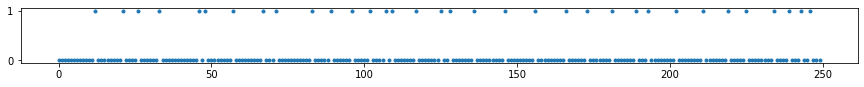

15 7 tensor(128.)


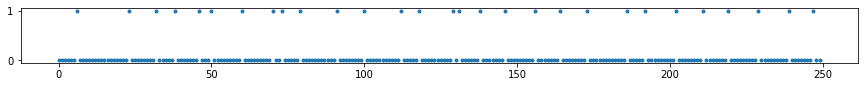

15 8 tensor(128.)


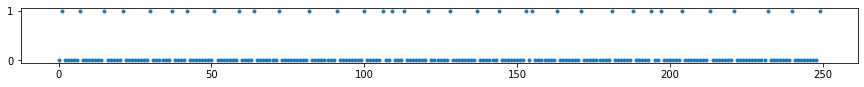

15 9 tensor(128.)


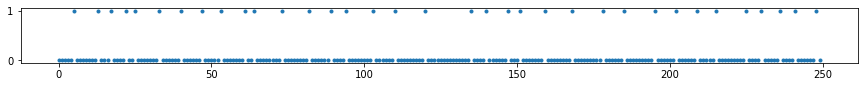

15 10 tensor(95.8745)


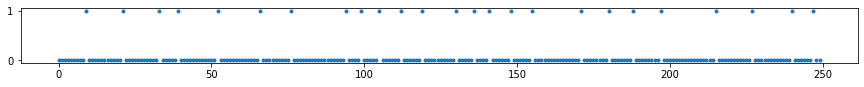

15 11 tensor(64.2510)


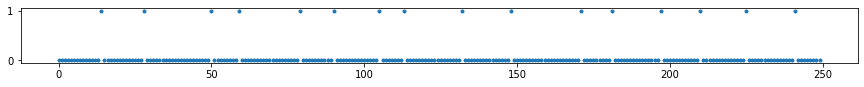

15 13 tensor(64.2510)


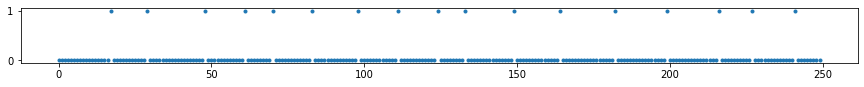

15 14 tensor(128.)


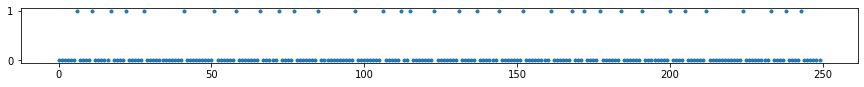

15 15 tensor(128.)


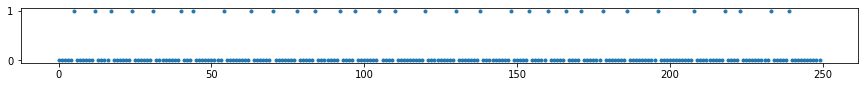

15 21 tensor(128.)


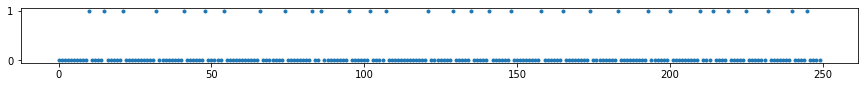

15 22 tensor(128.)


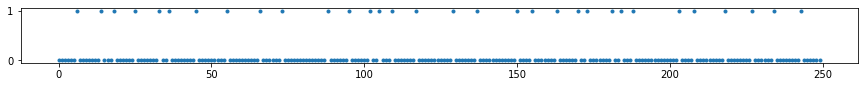

15 23 tensor(64.2510)


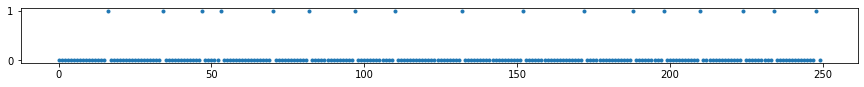

16 6 tensor(95.8745)


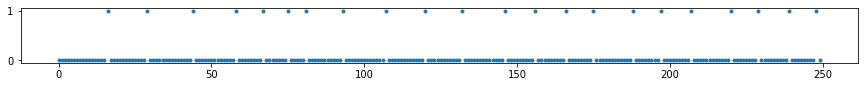

16 7 tensor(128.)


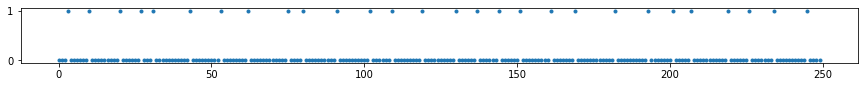

16 8 tensor(128.)


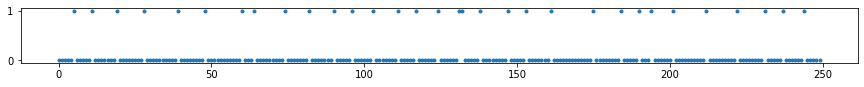

16 9 tensor(128.)


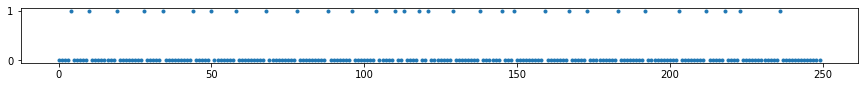

16 10 tensor(128.)


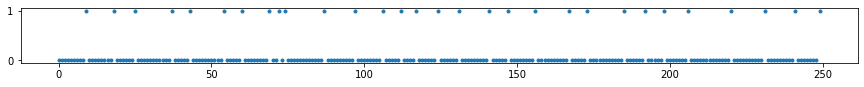

16 11 tensor(128.)


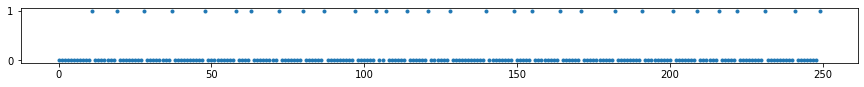

16 12 tensor(95.8745)


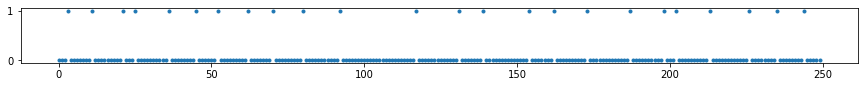

16 13 tensor(128.)


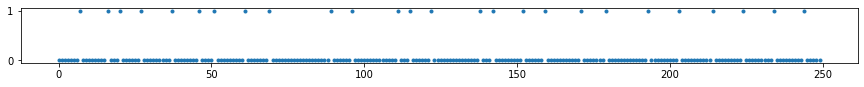

16 14 tensor(128.)


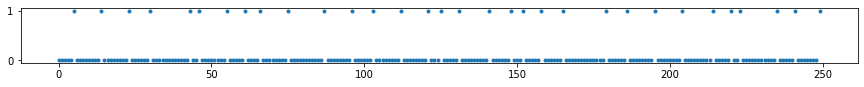

16 15 tensor(128.)


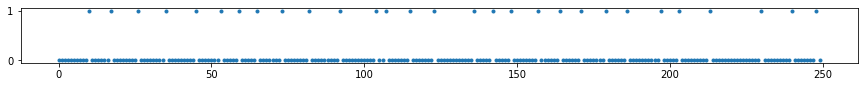

16 16 tensor(95.8745)


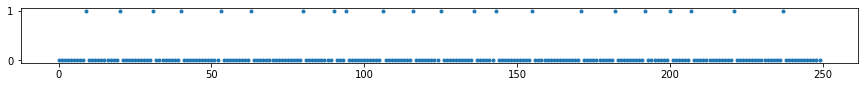

16 17 tensor(64.2510)


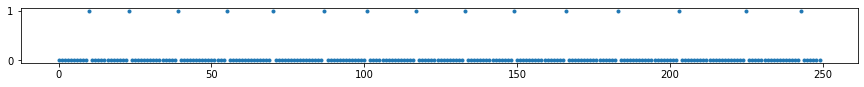

16 18 tensor(64.2510)


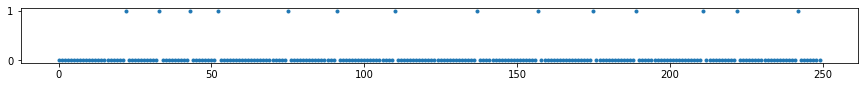

16 19 tensor(128.)


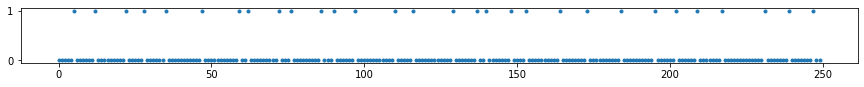

16 20 tensor(128.)


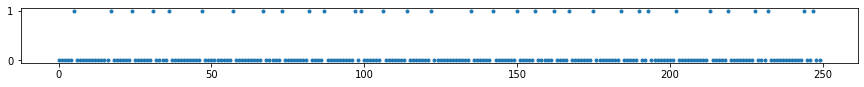

16 21 tensor(128.)


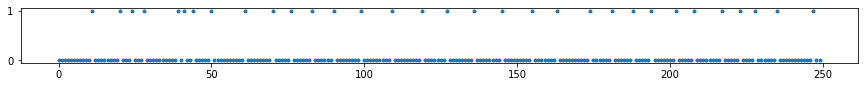

16 22 tensor(95.8745)


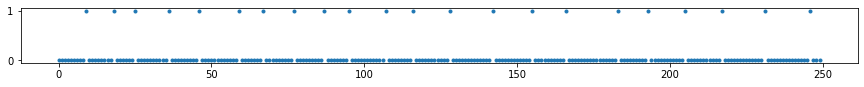

17 7 tensor(128.)


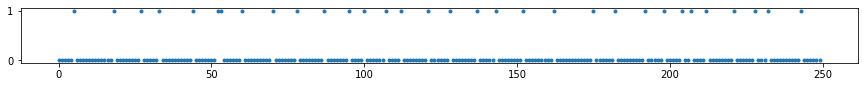

17 8 tensor(128.)


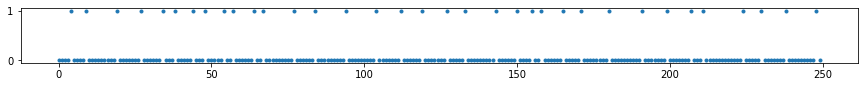

17 9 tensor(128.)


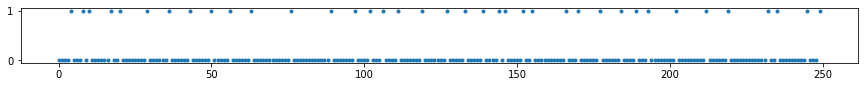

17 10 tensor(128.)


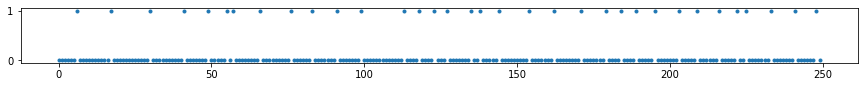

17 11 tensor(128.)


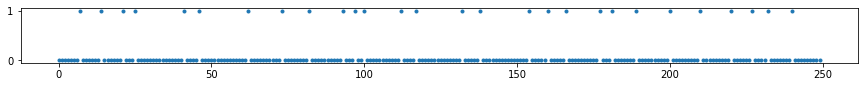

17 12 tensor(128.)


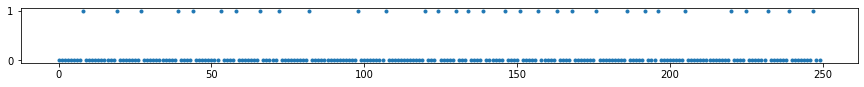

17 13 tensor(128.)


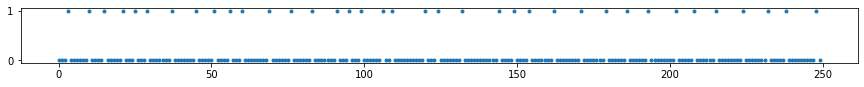

17 14 tensor(128.)


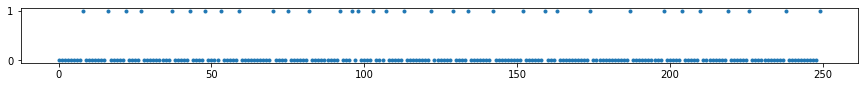

17 15 tensor(128.)


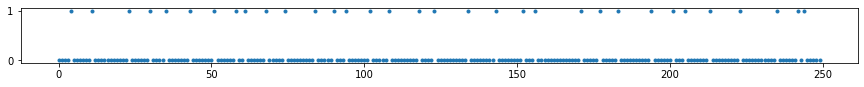

17 16 tensor(128.)


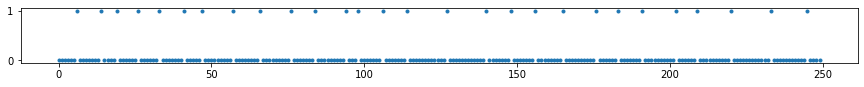

17 17 tensor(128.)


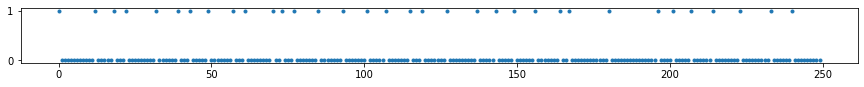

17 18 tensor(128.)


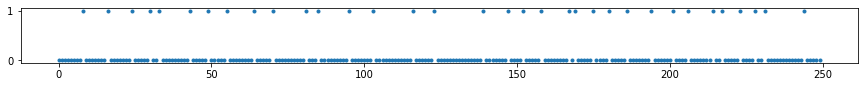

17 19 tensor(128.)


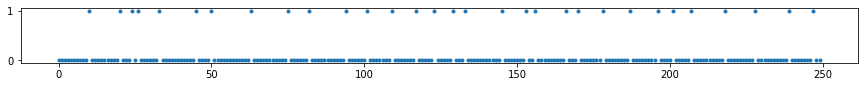

17 20 tensor(128.)


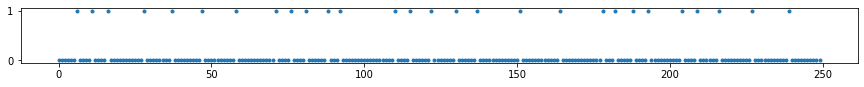

17 21 tensor(128.)


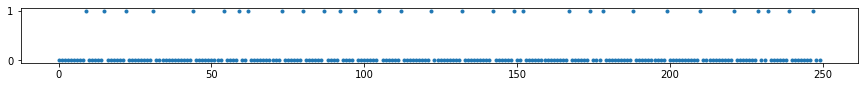

17 22 tensor(64.2510)


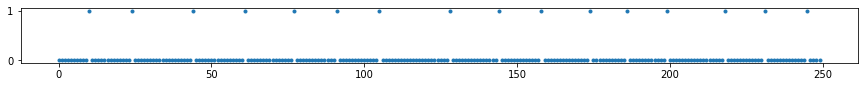

18 7 tensor(95.8745)


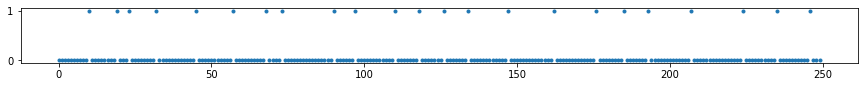

18 8 tensor(128.)


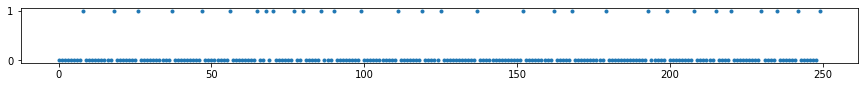

18 9 tensor(128.)


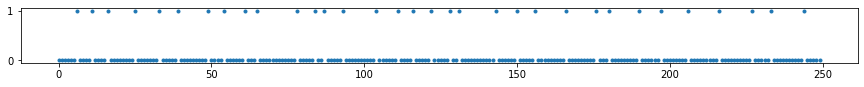

18 10 tensor(128.)


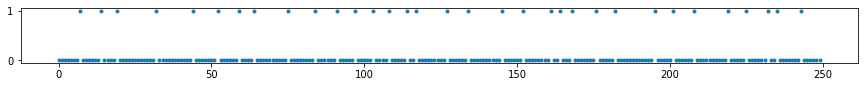

18 11 tensor(128.)


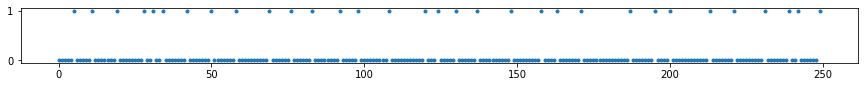

18 12 tensor(128.)


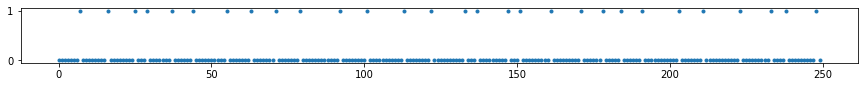

18 13 tensor(128.)


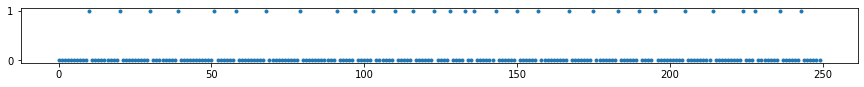

18 14 tensor(128.)


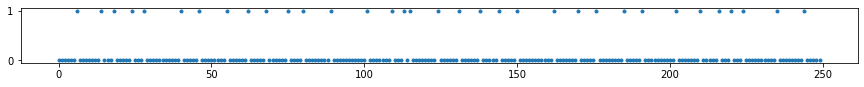

18 15 tensor(128.)


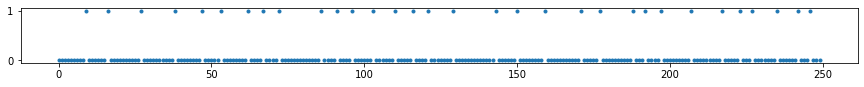

18 16 tensor(128.)


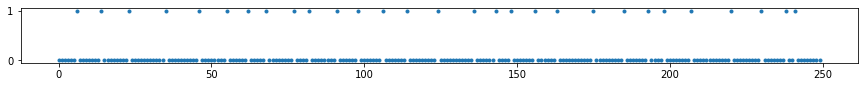

18 17 tensor(128.)


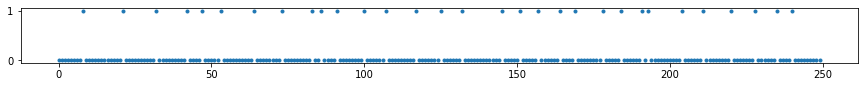

18 18 tensor(128.)


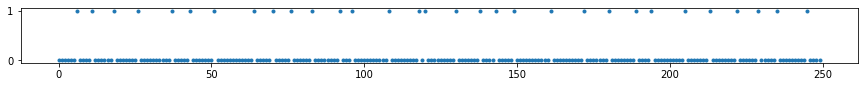

18 19 tensor(128.)


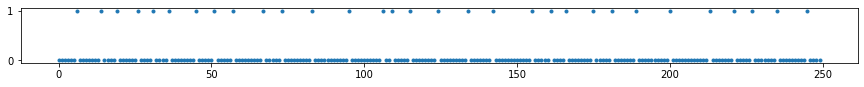

18 20 tensor(128.)


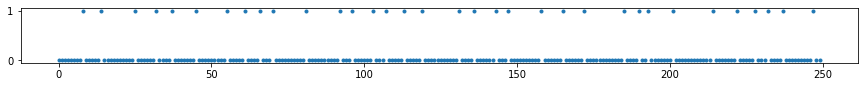

18 21 tensor(64.2510)


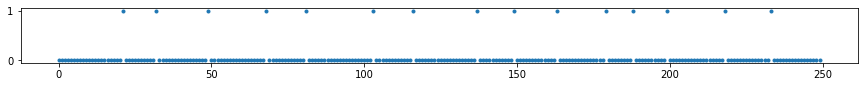

19 7 tensor(64.2510)


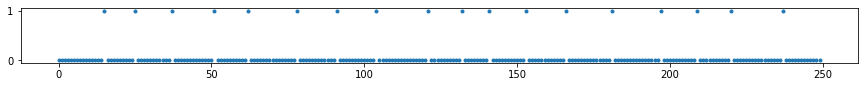

19 8 tensor(128.)


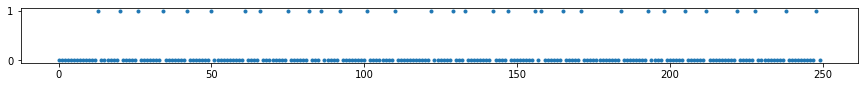

19 9 tensor(128.)


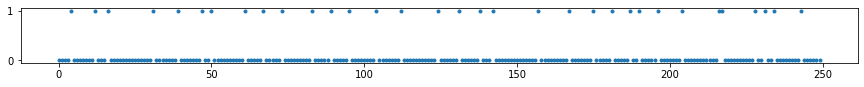

19 10 tensor(128.)


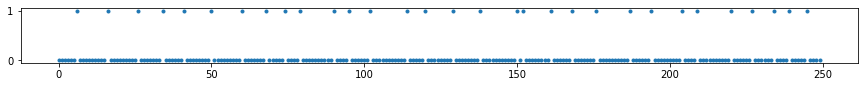

19 11 tensor(128.)


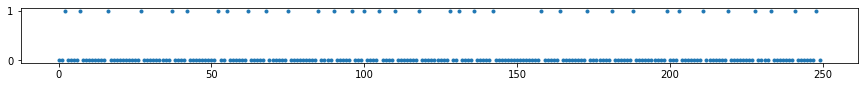

19 12 tensor(128.)


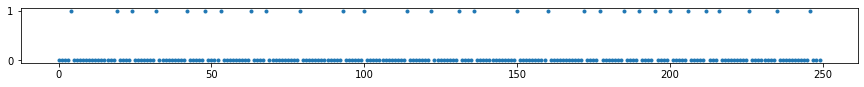

19 13 tensor(128.)


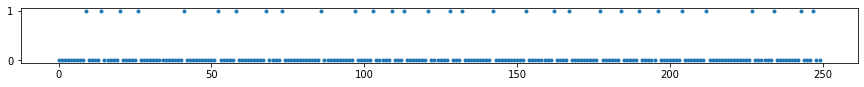

19 14 tensor(128.)


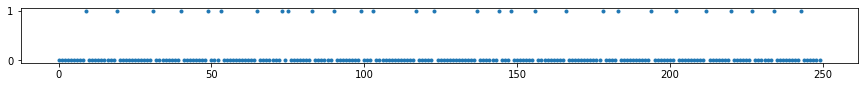

19 15 tensor(128.)


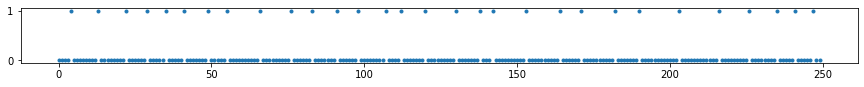

19 16 tensor(128.)


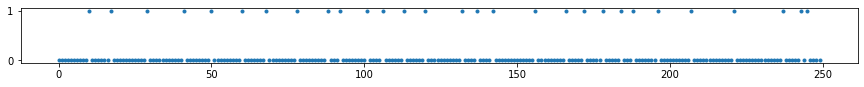

19 17 tensor(128.)


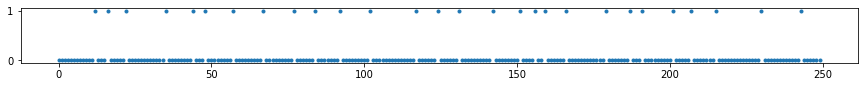

19 18 tensor(128.)


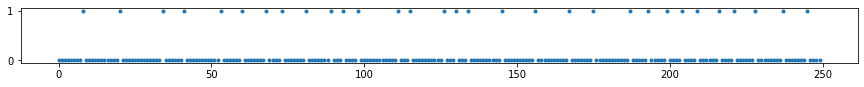

19 19 tensor(32.1255)


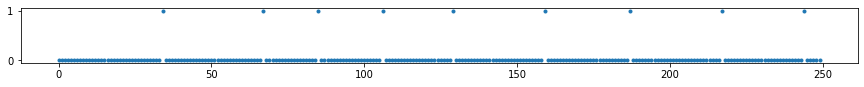

20 9 tensor(64.2510)


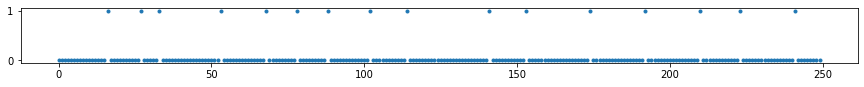

20 10 tensor(128.)


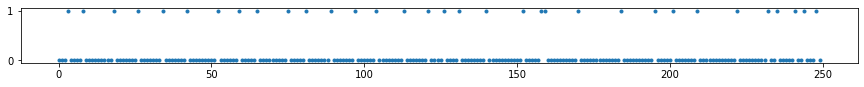

20 11 tensor(128.)


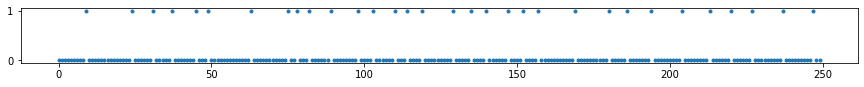

20 12 tensor(128.)


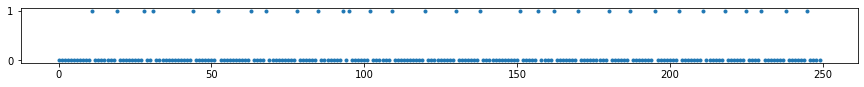

20 13 tensor(128.)


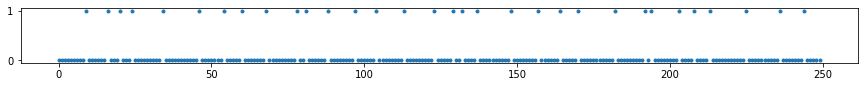

20 14 tensor(64.2510)


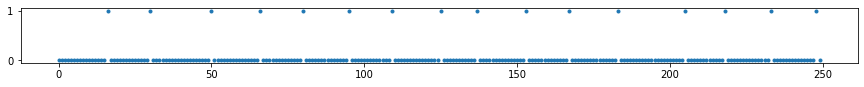

20 15 tensor(64.2510)


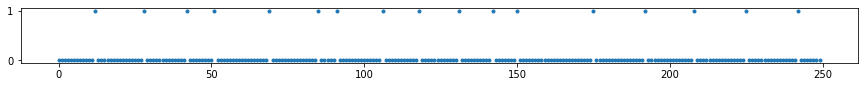

In [54]:
# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=n_workers, pin_memory=gpu
)

for step, batch in enumerate(dataloader):
    # Get next input sample.

    inputs = {"X": batch["encoded_image"].view(time, 1, 1, 28, 28)}
    for i in range(28):
        for j in range(28):
            if np.count_nonzero(inputs["X"][:, 0, 0, i, j]):
                print(i,j,batch["image"][0,0,i,j])
                plt.figure(figsize=[15,1])
                plt.plot(inputs["X"][:, 0, 0, i, j], marker='.', linestyle='')
                plt.show()
    break